## Steel Plate Defect Prediction



### Neural Network Classifier

In this notebook a fully connected Neural Network will be used to classify the different steel plate defects. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from pipeline import Pipeline

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns 

### Exploarory data analysis

In [2]:
df_train = pd.read_csv("Data/train.csv")
pl = Pipeline(df_train, True)
df_train, le, sc = pl.run()

In [3]:
df_test = pd.read_csv("Data/test.csv")
pl = Pipeline(df_test, False)
df_test = pl.run(le, sc)

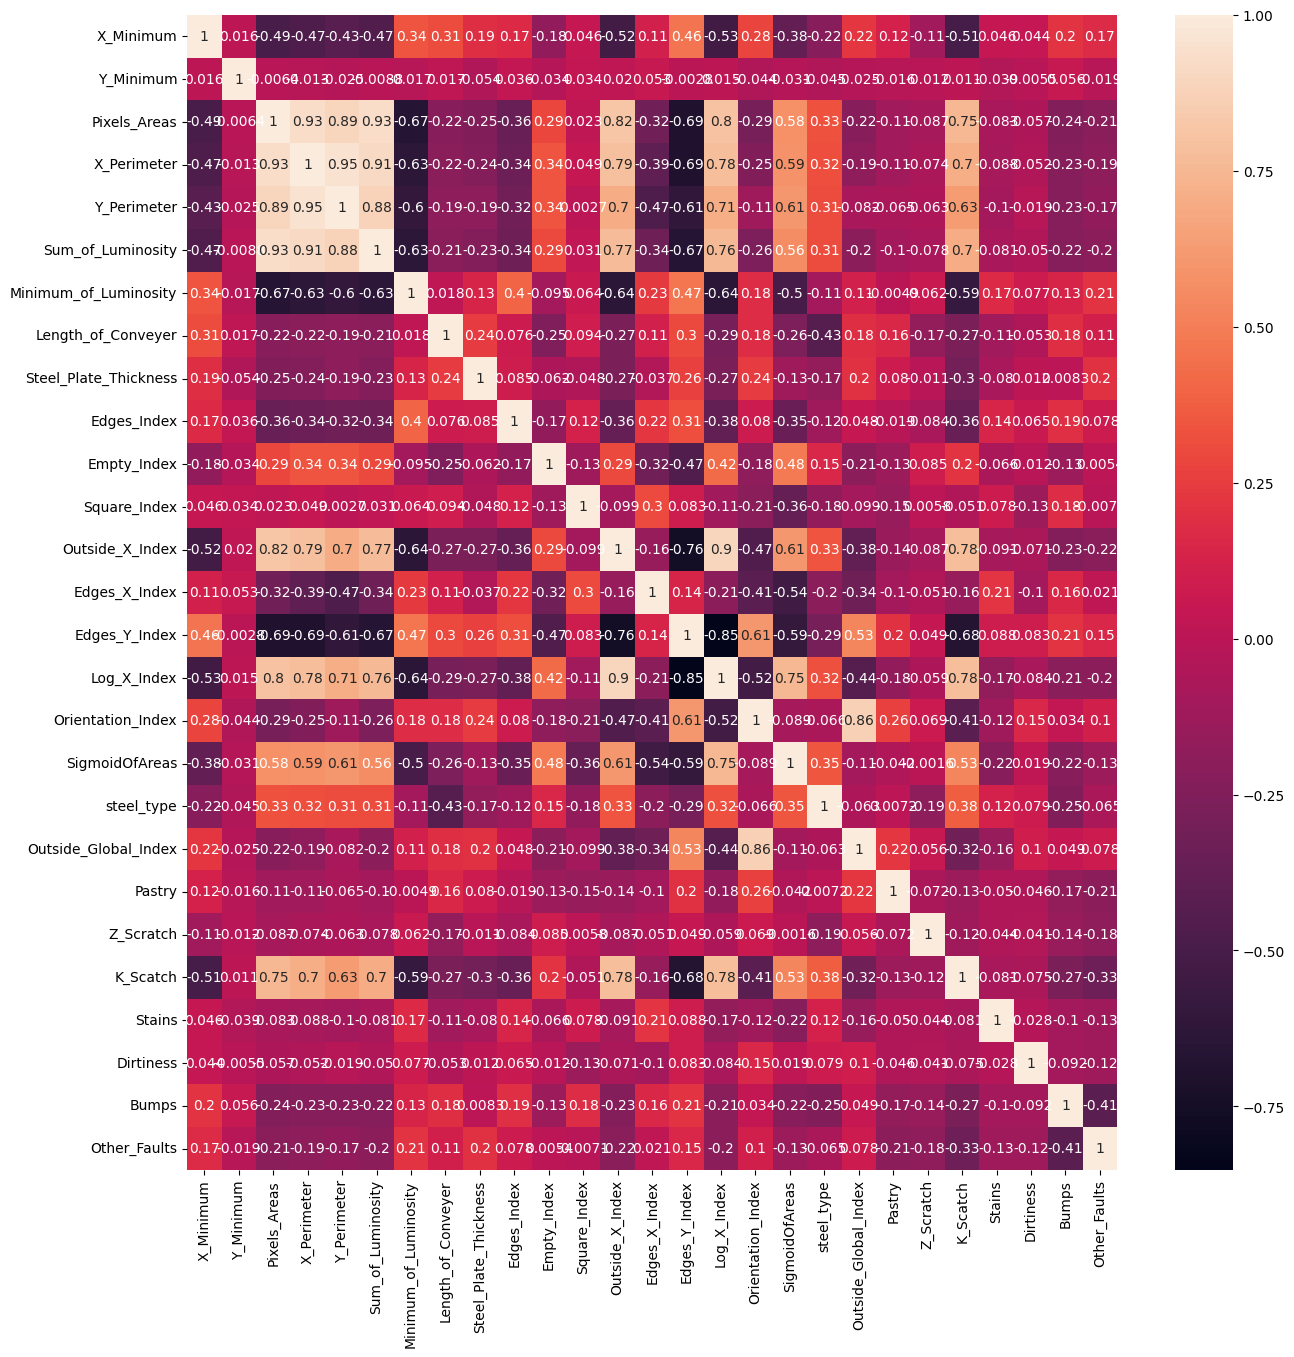

In [4]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_train.corr(), annot=True)
plt.show()

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19206 entries, 0 to 19205
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   X_Minimum              19206 non-null  float64 
 1   Y_Minimum              19206 non-null  float64 
 2   Pixels_Areas           19206 non-null  float64 
 3   X_Perimeter            19206 non-null  float64 
 4   Y_Perimeter            19206 non-null  float64 
 5   Sum_of_Luminosity      19206 non-null  float64 
 6   Minimum_of_Luminosity  19206 non-null  float64 
 7   Length_of_Conveyer     19206 non-null  float64 
 8   Steel_Plate_Thickness  19206 non-null  float64 
 9   Edges_Index            19206 non-null  float64 
 10  Empty_Index            19206 non-null  float64 
 11  Square_Index           19206 non-null  float64 
 12  Outside_X_Index        19206 non-null  float64 
 13  Edges_X_Index          19206 non-null  float64 
 14  Edges_Y_Index          19206 non-null 

### Model
#### Data Loader

In [6]:
class CustomDataLoader:
    def __init__(self, data, target, cat_cols=None, cont_cols=None, val_size=0.05, test_size=0.2, batch_size=2048):  
        self.batch_size = batch_size
        
        # Preprocess categorical variables 
        cats = []
        for cat in cat_cols:
            data[cat] = data[cat].astype('category')
            vec = data[cat].cat.codes.values
            cats.append(vec)
        cats = np.stack(cats, 1)
        
        cat_szs = [len(data[col].cat.categories) for col in cat_cols]
        self.emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
        
        # Preprocess continuous variables
        conts = []
        for con in cont_cols:
            vec = data[con].values
            conts.append(vec)
        conts = np.stack(conts, 1)

        # Concatenate categorical and continuous variables
        X = np.hstack((cats, conts))
        
        # Split data into train, validation, and test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, target.values, test_size=test_size, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(1-test_size), random_state=42)

        # Separate categorical and continuous variables
        self.cat_train, self.cat_val, self.cat_test = X_train[:, :cats.shape[1]], X_val[:, :cats.shape[1]], X_test[:, :cats.shape[1]]
        self.cont_train, self.cont_val, self.cont_test = X_train[:, cats.shape[1]:], X_val[:, cats.shape[1]:], X_test[:, cats.shape[1]:]
        self.y_train, self.y_val, self.y_test = y_train, y_val, y_test

    def get_data_loaders(self):
        # Combine categorical and continuous features with target into one TensorDataset
        train_dataset = TensorDataset(
            torch.tensor(self.cat_train, dtype=torch.long), 
            torch.tensor(self.cont_train, dtype=torch.float32),
            torch.tensor(self.y_train, dtype=torch.float32))
        val_dataset = TensorDataset(
            torch.tensor(self.cat_val, dtype=torch.long), 
            torch.tensor(self.cont_val, dtype=torch.float32),
            torch.tensor(self.y_val, dtype=torch.float32))
        test_dataset = TensorDataset(
            torch.tensor(self.cat_test, dtype=torch.long), 
            torch.tensor(self.cont_test, dtype=torch.float32),
            torch.tensor(self.y_test, dtype=torch.float32))

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader, test_loader


X = df_train.drop(columns=['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains','Dirtiness', 'Bumps', 'Other_Faults'])
y = df_train[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains','Dirtiness', 'Bumps', 'Other_Faults']]
cat_cols = list(df_train.select_dtypes(include=['category']).columns)

cont_cols = ['X_Minimum', 'Y_Minimum', 'Pixels_Areas', 'X_Perimeter', 
    'Y_Perimeter','Sum_of_Luminosity','Minimum_of_Luminosity', 'Length_of_Conveyer', 
    'Steel_Plate_Thickness', 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 
    'Edges_X_Index', 'Edges_Y_Index', 'Log_X_Index', 'Orientation_Index', 'SigmoidOfAreas']


custom_loader = CustomDataLoader(X, y, cat_cols, cont_cols)
train_loader, val_loader, test_loader = custom_loader.get_data_loaders()

#### Neural Network 

In [7]:
class Model(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        y_pred = F.log_softmax(x, dim=1)
        return y_pred



# Define input and output sizes
model = Model(custom_loader.emb_szs, len(cont_cols), y.shape[1], [256, 128, 64], p=0.6) 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

### Training

Epoch 1/500, Train Loss: 2.1073, Test Loss: 1.8540
Epoch 2/500, Train Loss: 1.8584, Test Loss: 1.8387
Epoch 3/500, Train Loss: 1.8392, Test Loss: 1.8167
Epoch 4/500, Train Loss: 1.8160, Test Loss: 1.7933
Epoch 5/500, Train Loss: 1.7920, Test Loss: 1.7700
Epoch 6/500, Train Loss: 1.7685, Test Loss: 1.7475
Epoch 7/500, Train Loss: 1.7458, Test Loss: 1.7259
Epoch 8/500, Train Loss: 1.7241, Test Loss: 1.7048
Epoch 9/500, Train Loss: 1.7032, Test Loss: 1.6841
Epoch 10/500, Train Loss: 1.6826, Test Loss: 1.6635
Epoch 11/500, Train Loss: 1.6621, Test Loss: 1.6431
Epoch 12/500, Train Loss: 1.6420, Test Loss: 1.6228
Epoch 13/500, Train Loss: 1.6217, Test Loss: 1.6020
Epoch 14/500, Train Loss: 1.6010, Test Loss: 1.5805
Epoch 15/500, Train Loss: 1.5795, Test Loss: 1.5582
Epoch 16/500, Train Loss: 1.5575, Test Loss: 1.5353
Epoch 17/500, Train Loss: 1.5346, Test Loss: 1.5116
Epoch 18/500, Train Loss: 1.5112, Test Loss: 1.4875
Epoch 19/500, Train Loss: 1.4874, Test Loss: 1.4629
Epoch 20/500, Train L

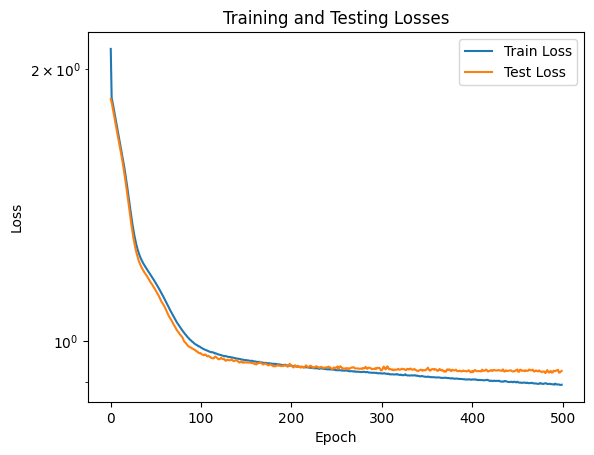

0.8703267684741848


In [8]:
class Trainer:
    def __init__(self, model, optimizer, criterion, train_loader, val_loader):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
    
    def train(self, max_epochs):
        self.train_losses = []
        self.val_losses = []

        # Training
        for epoch in range(max_epochs):
            self.model.train
            train_loss = 0

            for cat_inputs, cont_inputs, labels in self.train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(cat_inputs, cont_inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item() * cat_inputs.size(0)
            train_loss /= len(self.train_loader.dataset)
            self.train_losses.append(train_loss)

            # Validation
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for cat_inputs, cont_inputs, labels in self.val_loader:
                    outputs = self.model(cat_inputs, cont_inputs)
                    loss = self.criterion(outputs, labels)
                    val_loss += loss.item() * cat_inputs.size(0)
                val_loss /= len(self.val_loader.dataset)
            self.val_losses.append(val_loss)

            if epoch % 1 == 0:
                print(f'Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}')
 
        return self.model
    
    def plot_losses(self, train_losses, test_losses):
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')  
        plt.title('Training and Testing Losses')
        plt.legend()
        plt.show()
    
    def evaluation(self, model, test_loader):
        model.eval()
        with torch.no_grad():
            for cat_inputs, cont_inputs, labels in test_loader:
                outputs = model(cat_inputs, cont_inputs)
                score = roc_auc_score(labels, outputs, multi_class="ovr")
        print(score)
            

trainer = Trainer(model, optimizer, criterion, train_loader, val_loader)   
model = trainer.train(500)      
trainer.plot_losses(trainer.train_losses, trainer.val_losses)
trainer.evaluation(model, test_loader)